In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
##### CREATING INPUT AND OUTPUT DATA FOR THE TRANSLATION PROCESS

TRANSLATION_FILE_PATH = '/content/gdrive/My Drive/NLP project/spa.txt'
GLOVE_PATH = '/content/gdrive/My Drive/NLP project/glove.6B/glove.6B.100d.txt'
MODEL_SAVE_PATH = '/content/gdrive/My Drive/NLP project/'

# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 20  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_OF_LINES = 15000  # Number of lines to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

def load_data(TRANSLATION_FILE_PATH,NUM_OF_LINES):
  input_data = [] # sentence in original language
  target_text_outputs = [] # sentence in target language
  target_texts_inputs = [] # sentence in target language offset by 1

  count = 0
  for line in open(TRANSLATION_FILE_PATH):

    count += 1
    if count > NUM_OF_LINES:
      break

    input_language, translated_language = line.rstrip().split('\t')

    target_text_output = translated_language + ' <eos>'
    target_text_input = '<sos> ' + translated_language

    input_data.append(input_language)
    target_text_outputs.append(target_text_output)
    target_texts_inputs.append(target_text_input)
 
  return (input_data,target_text_outputs,target_texts_inputs)


#### loading the data into input,target_input

input_texts,target_texts,target_texts_inputs = load_data(TRANSLATION_FILE_PATH, NUM_OF_LINES)

print("The input data length = {}".format(len(input_texts)))

print("The target data length = {}".format(len(target_texts)))

print("The input data length ( input ) = {}".format(len(target_texts_inputs)))

The input data length = 15000
The target data length = 15000
The input data length ( input ) = 15000


In [0]:
#### tokenize input and output

def tokenize_input(input_texts):
  
  tokenizer_inputs = Tokenizer()
  tokenizer_inputs.fit_on_texts(input_texts)
  input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

  # get the word to index mapping for input language
  word_input_dict = tokenizer_inputs.word_index
  print('Found {} unique input tokens.'.format(len(word_input_dict)))

  # determine maximum length input sequence

  max_len_input = max(len(each_line) for each_line in input_sequences)
  print("The max input length is {}".format(max_len_input))
  
  return (input_sequences,word_input_dict,max_len_input)


def tokenize_output(target_texts,target_texts_inputs):

  tokenizer_outputs = Tokenizer(filters='')
  tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
  target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
  target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)
  
  
  word_output_dict = tokenizer_outputs.word_index
  print('Found {} unique output tokens.'.format(len(word_output_dict)))
                                             
  #  adding 1 since indexing starts at 1
  num_words_output = len(word_output_dict) + 1

# determine maximum length output sequence
  max_len_target = max(len(s) for s in target_sequences)
  
  return (target_sequences,target_sequences_inputs, word_output_dict,max_len_target,num_words_output)


#### Tokenizing by calling the above functions

input_sequences,word_input_dict,max_len_input = tokenize_input(input_texts)
target_sequences,target_sequences_inputs, word_output_dict,max_len_target,num_words_output = tokenize_output(target_texts,target_texts_inputs)


Found 3179 unique input tokens.
The max input length is 6
Found 8514 unique output tokens.


In [0]:
# padding for encoder_inputs , decoder_inputs, and decoder_targets

encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

print("The shapes of encoder, decorder_input, and decoder_target are {}, {}, {}".format(encoder_inputs.shape,decoder_inputs.shape, decoder_targets.shape))

The shapes of encoder, decorder_input, and decoder_target are (15000, 6), (15000, 10), (15000, 10)


In [0]:
# store Glove pretrained word vec

def load_glove(PATH):
  glove = {}
  with open(os.path.join(PATH)) as f:

    for line in f:
      values = line.split()
      word = values[0]
      vec = np.asarray(values[1:], dtype='float32')
      glove[word] = vec

  print("Total size of words in glove = {}".format(len(glove)))
  return glove
        
# creating glove 
glove = load_glove(GLOVE_PATH)
        

Total size of words in glove = 400000


In [0]:
#### creating input embedding matrix 

def embedding_matrix(word_input_dict,MAX_NUM_WORDS) : 
  
  
    print('Filling pre-trained embeddings...')
    num_words = MAX_NUM_WORDS
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_input_dict.items():
      if i < MAX_NUM_WORDS:
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = embedding_matrix(word_input_dict,MAX_NUM_WORDS)


embedding_layer = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len_input )

Filling pre-trained embeddings...


In [0]:
# create embedding layer
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences

decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [0]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))

x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  dropout=0.5 # dropout not available on gpu
)


Instructions for updating:
Colocations handled automatically by placer.


In [0]:

encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# we can discard encoder_outputs and keep only the states to pass into decoder
encoder_states = [h, c]



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)


decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [0]:
#################################################################

# Create the model object

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Compile the model and train it
model.compile(
  optimizer='Adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

history  = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

# Save model
file_path = os.path.join(MODEL_SAVE_PATH, 's2s.h5')
model.save(file_path)



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 12000 samples, validate on 3000 samples
Epoch 1/20
12000/12000 [==============================] - 16s 1ms/step - loss: 2.9250 - acc: 0.6565 - val_loss: 2.7721 - val_acc: 0.6601
Epoch 2/20
12000/12000 [==============================] - 13s 1ms/step - loss: 2.1609 - acc: 0.7135 - val_loss: 2.6070 - val_acc: 0.6602
Epoch 3/20
12000/12000 [==============================] - 13s 1ms/step - loss: 1.9688 - acc: 0.7245 - val_loss: 2.4092 - val_acc: 0.6776
Epoch 4/20
12000/12000 [==============================] - 13s 1ms/step - loss: 1.7857 - acc: 0.7380 - val_loss: 2.2682 - val_acc: 0.6944
Epoch 5/20
12000/12000 [==============================] - 13s 1ms/step - loss: 1.6240 - acc: 0.7528 - val_loss: 2.1566 - val_acc: 0.7054
Epoch 6/20
12000/12000 [==============================] - 13s 1ms/step - loss: 1.4860 - acc: 0.7671 - val_loss: 2.0880 - val_acc: 0.7160
Epo

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


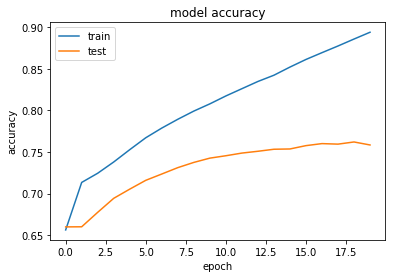

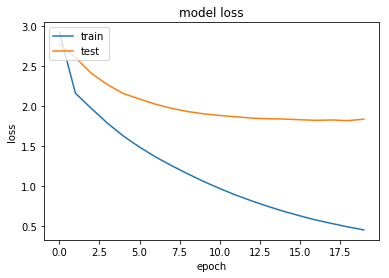

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:

##########################################
# creating another decoder for predictions

encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))

decoder_state_input_c = Input(shape=(LATENT_DIM,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))

decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word_input_dict.items()}
idx2word_trans = {v:k for k, v in word_output_dict.items()}


def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word_output_dict['<sos>']

  # if we get this we break
  eos = word_output_dict['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


while True:
  # Do some test translations
  ###########################
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break



-
Input: It's worth it.
Translation: es la hecho.
Continue? [Y/n]y
-
Input: I paid my bills.
Translation: pagué mis cuentas.
Continue? [Y/n]y
-
Input: Do you like music?
Translation: ¿te gusta el té?
Continue? [Y/n]y
-
Input: The well is dry.
Translation: el pozo está seco.
Continue? [Y/n]y
-
Input: Love lasts.
Translation: el amor dura.
Continue? [Y/n]y
-
Input: Tom likes cheese.
Translation: a tom le gusta el jazz.
Continue? [Y/n]y
-
Input: Tom is guilty.
Translation: tom es culpable.
Continue? [Y/n]y
-
Input: Stop arguing.
Translation: deja de preocuparte.
Continue? [Y/n]y
-
Input: I eat bread.
Translation: yo disfruto jugar póker.
Continue? [Y/n]y
-
Input: You got hit hard.
Translation: me veo una mano.
Continue? [Y/n]n
